# **Sun-as-a-star analysis of coronal high-frequency quasi-periodic oscillations observed by an iPhone during the total solar eclipse of 20 April 2023 with 240 fps imaging**
### **Data Processing and Analysis Notebook**

**Authors**: [Yu Liang]
**Affiliation**: [Shanghai Astronomical Observatory, Chinese Academy of Sciences, Shanghai 200030, China]  
**Contact**: [yuliang@shao.ac.cn]  
**Last Updated**: [2024-12-10]  

---

### **Notebook Overview**

These Jupyter Notebook documents the processing and analysis of observational data collected during the 2023 total solar eclipse. The primary objectives of this Notebook include:

1. Preprocessing of raw white-light corona imaging data (dark field subtraction, flat field correction, and temporal registration).
2. Application of wavelet analysis to detect high-frequency quasi-periodic oscillations (HFQPOs).
3. Visualizations of the solar corona and statistical results for Sun-as-a-star analysis.

---

### **Dependencies**

The analysis relies on the following Python libraries (compatible versions):  
- `numpy==1.2.43`  
- `pandas==1.5.1`  
- `scikit-image==0.20.0`  
- `matplotlib==3.7.1`  
- `astropy==5.1.1`  
- `opencv-python==4.7.0.72`  
- `Pillow==9.2.0`  
- `scipy==1.13.1`  


<!-- A complete list of dependencies can be found in the accompanying `requirements.txt`. -->

---

### **Data Source**

- **Observation Site**: Learmonth Airport, Australia  
- **Instrument**: iPhone with 565 nm filter, sampling at 240 fps, frams width * height: 720.0 * 1280.0, image shape:(1280, 720, 3)  
- **Date**: April 20, 2023  

---

### **Main Structure**

- **Section 1**: Data loading and inspection  
- **Section 2**: Preprocessing (dark field, flat field, and registration)  
- **Section 3**: Wavelet analysis and signal detection  
- **Section 4**: Results visualization and discussion  

---
### **Notebook 7.1**
#### Wavelet analysis of the slicer: R1.006-R1.1. 
- input: *.npy
- output: *.png

STEP 1: file load. 

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 
import struct
import imageio as iio
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import cv2

---
### **Notebook 7.1**
#### Wavelet analysis of the slicer: R1.006-R1.1. 
- input: *.npy
- output: *.png

STEP 2:  Excluded files
- To mitigate these variations, data from the first and last seconds of totality were excluded from the analysis. Therefore, we focused on the 52-second interval from 03:29:14 to 03:30:06 UTC, representing the central portion of the 54-second period of totality.
- The correspongding frames No. are: 240*52 = 12480 = 12960 - 480
- start No. is 480, while the ending No. is 12480

In [16]:
# 设置绘图风格为Nature常用风格
plt.style.use('seaborn-white')  # 更简洁的背景

# 设置全局字体
plt.rcParams.update({
    'font.family': 'serif',   # 使用serif字体，符合Nature的风格
    'font.serif': ['Times New Roman'],  # 指定字体为Times New Roman
    'axes.titlesize': 14,  # 设置坐标轴标题字体大小
    'axes.labelsize': 12,  # 设置坐标轴标签字体大小
    'xtick.labelsize': 10,  # 设置x轴刻度字体大小
    'ytick.labelsize': 10,  # 设置y轴刻度字体大小
    'legend.fontsize': 10,  # 设置图例字体大小
    'figure.dpi': 300,  # 设置图片分辨率为300DPI，符合高质量论文要求
    'savefig.dpi': 300,  # 保存图像时也使用300DPI
})

/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_21472/818244284.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # 更简洁的背景


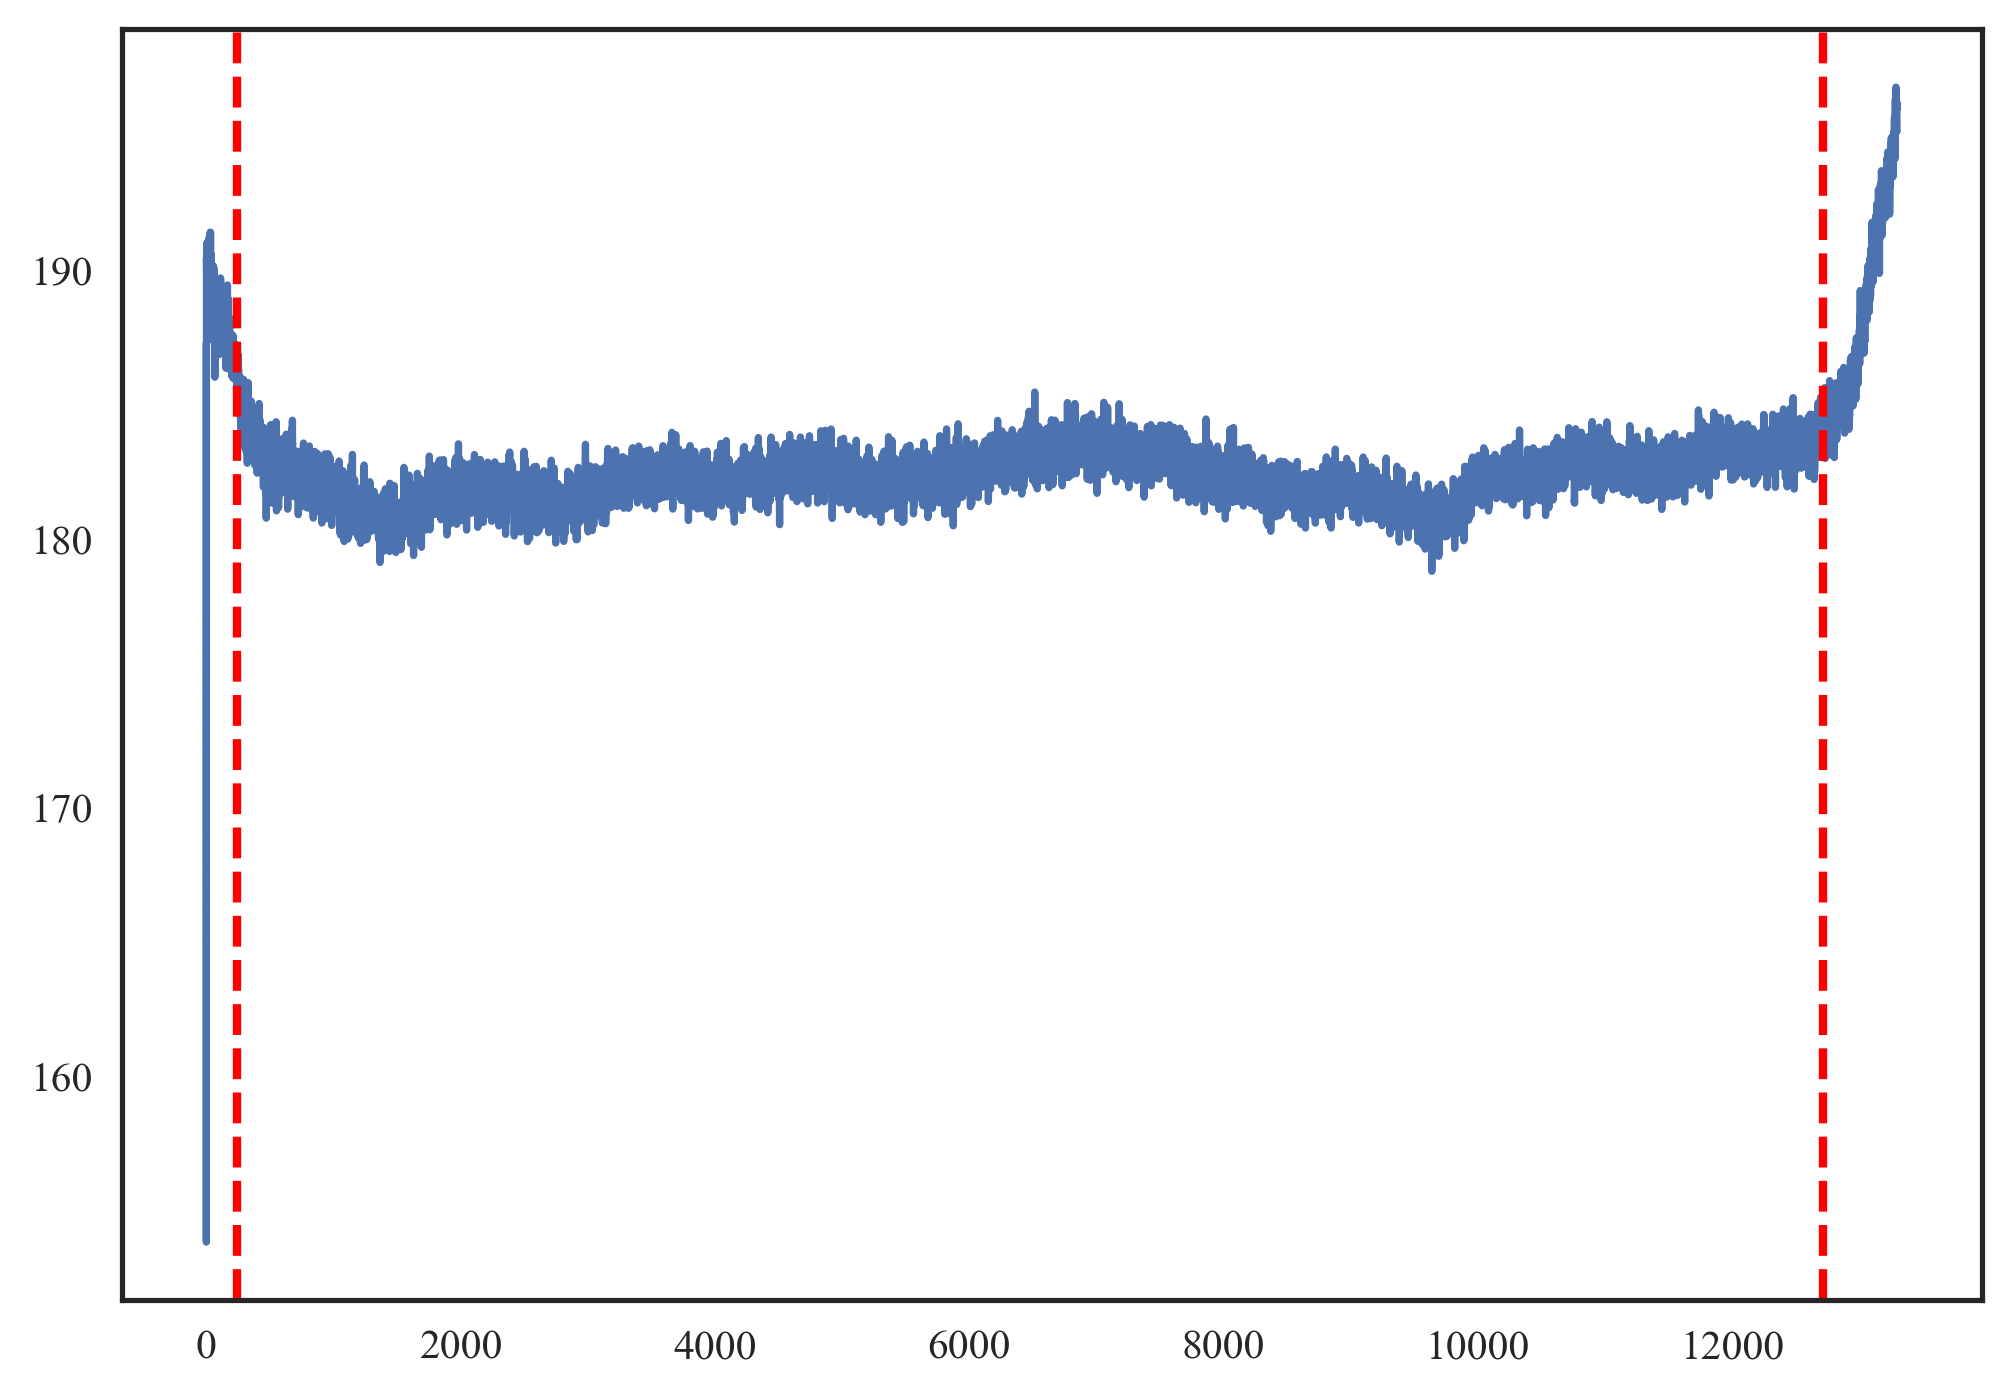

In [17]:
frn = 1 # frame number

mdata = np.load('./output/mrdata.npy')

# Pre-defined radii multipliers
MULTIPLIERS = np.arange(1.1, 8.6, 0.1)

# Corresponding Slicer No.
nn = int(MULTIPLIERS[frn]*10)              # save name of the wavelet result.
snn = str(nn)           # STRING format of the save name of the wavelet result.
lnm = (nn-1)/10         # slicer radial height (lower part)
lnm = str(lnm)
hn = nn/10              # slicer radial height (higher part)
hnm = str(hn)

# start frame No.= 240
# end frame No. = 12720
sno, eno = 240, 12720
ts = (eno - sno) / 240

dat = mdata[frn,:]         # corresponding the average value of the polar form image: [ridx:r11,:]
plt.plot(dat)
plt.axvline(x=sno, color='r', linestyle='--', linewidth=2)
plt.axvline(x=eno, color='r', linestyle='--', linewidth=2)
plt.show()



---
### **Notebook 7.1**
#### Wavelet analysis of the slicer: R1.006-R1.1. 
- input: *.npy
- output: *.png

STEP 3:  Wavlet analysis of the slicer.

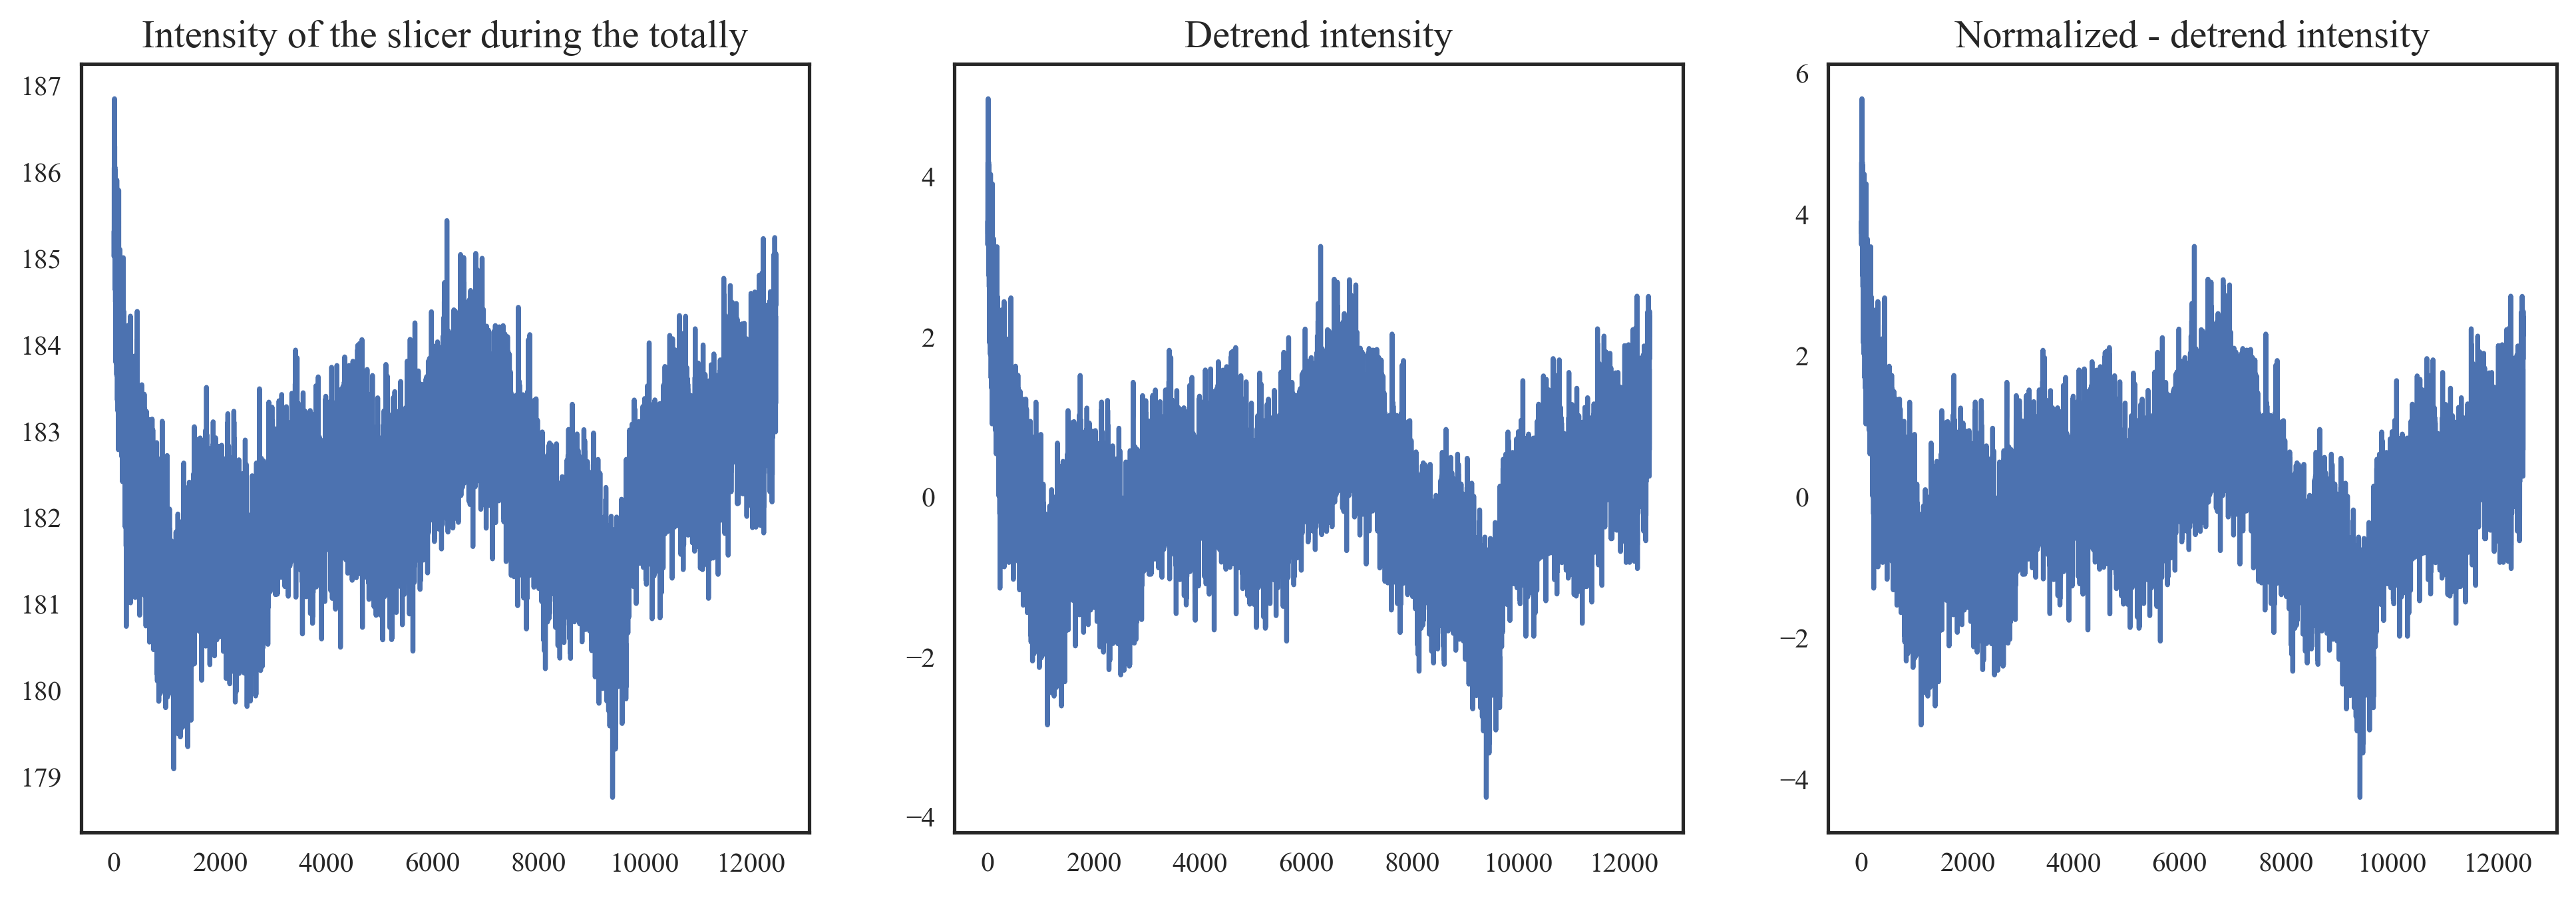

/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_21472/3940761992.py:127: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


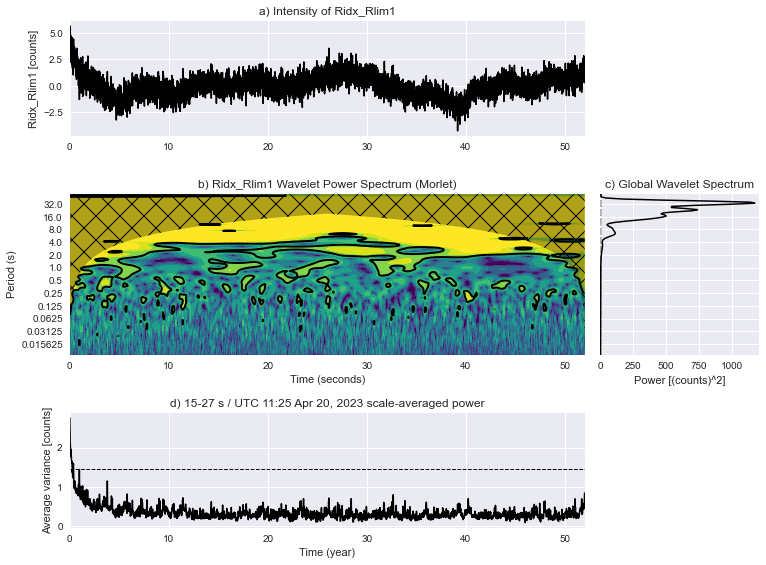

In [18]:
from __future__ import division
import numpy
from matplotlib import pyplot

import pycwt as wavelet
from pycwt.helpers import find

ctf = eno - sno  # 12000 # ctf: cut frame
dt = (ts) / (ctf - 1)  # In seconds
dat = dat[sno:eno]
#dat = dat / np.abs(np.max(dat))

title = 'Intensity of Ridx_Rlim1'
label = 'Ridx_Rlim1'
units = 'counts'
t0 = 0

# We also create a time array in years.
N = dat.size
t = np.arange(0, N) * dt + t0

mother = wavelet.DOG(6)
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octave
#J = 7 / dj  # Seven powers of two with dj sub-octaves
J = (np.log2(N * dt / s0)) / dj
#alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
#alpha, _, _ = 0,0,0
alpha = 0

# We write the following code to detrend and normalize the input data by its
# standard deviation. Sometimes detrending is not necessary and simply
# removing the mean value is good enough. However, if your dataset has a well
# defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# above mentioned website, it is strongly advised to perform detrending.
# Here, we fit a one-degree polynomial function and then subtract it from the
# original data.
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

#dat_norm = dat#_notrend / std    # Normalized dataset

# Intensity normalized during the sample time series.
plt.figure(figsize=[16,5])
plt.subplot(131)
plt.plot(dat)
plt.title('Intensity of the slicer during the totally')
plt.subplot(132)
plt.plot(dat_notrend)
plt.title('Detrend intensity')
plt.subplot(133)
plt.plot(dat_norm)
plt.title('Normalized - detrend intensity')
plt.show()


# https://qastack.cn/stats/134104/why-do-we-divide-by-the-standard-deviation-and-not-some-other-standardizing-fact
# The purpose of dividing by the standard deviation is to rescale each coordinate to have unit variance,
# ensuring that different attributes are processed on the same "scale." For example, if z represents the maximum
# speed of a car in miles per hour (ranging from tens to hundreds), and x2 represents the number of seats (around 2-4),
# this normalization rescales the different attributes to make them more comparable.
# If we know in advance that different attributes are on the same scale, steps (3-4) may be omitted.
# Therefore, we use dat_notrend instead of dat_norm. No need to divide by standard deviation again.
#dat_norm = dat_notrend 
# wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
#                                                       mother)
# iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std   

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std   

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However, we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
sel = find((period >= s0) & (period < 6))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()

import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn')

figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
#ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))
#plt.ylim(140,148)

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influence hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_xlabel('Time (seconds)')
bx.set_ylabel('Period (s)')
#fig.colorbar(im, cax=cbar_ax, orientation="vertical")
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
#cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        #linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() *0.8])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}-{} s / UTC 11:25 Apr 20, 2023 scale-averaged power'.format(15 , 27))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
#plt.ylim(0,0.1)
ax.set_xlim([t.min(), t.max()])
pyplot.show()


Calculated centroid: 17.60 seconds
Calculated sum power: 9361.88


/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_21472/2964933054.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


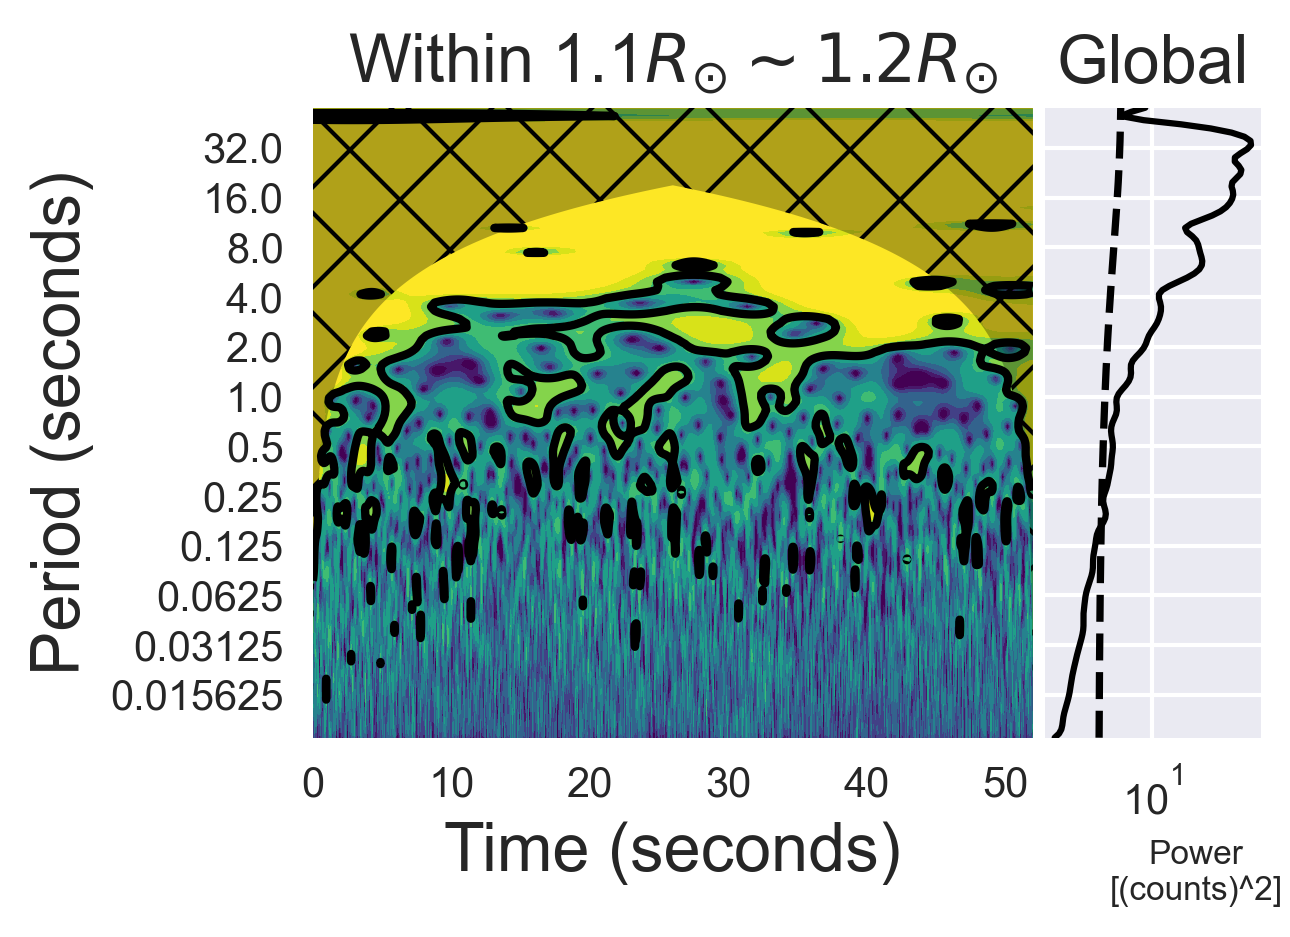

In [19]:
# Assuming that 'period', 'glbl_signif', 'fft_theor', 'glbl_power', 'sig95' and other data have been defined

# Centroid calculation function
def calculate_centroid(period, power):
    # Calculate the centroid: weighted average along the period direction
    centroid = np.sum(power * period) / np.sum(power)
    return centroid

# Initialize figure
units = 'counts'
figprops = dict(figsize=(4, 3))
fig = plt.figure(**figprops)

# Create second subplot bx: plot wavelet power spectrum
bx = plt.axes([0.1, 0.18, 0.6, 0.7], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), extend='both', cmap=plt.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2, extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt, t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                       np.log2(period[-1:]), [1e-9]]), 'k', alpha=0.3, hatch='x')
bx.set_title('Within ' + lnm +  '$R_{\odot} \sim ' + hnm +  ' R_{\odot}$', fontsize=16)
#bx.set_title('Within ' + '1.006 $R_{\odot} \sim ' + hnm +  ' R_{\odot}$', fontsize=16)
bx.set_xlabel('Time (seconds)', fontsize=16)
bx.set_ylabel('Period (seconds)', fontsize=16)

Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Select data within the period range of 0 to 26 seconds
period_range = (period >= 0) & (period <= 26)
period_selected = period[period_range]
glbl_power_selected = glbl_power[period_range]
sig95_selected = sig95[period_range]

# Select glbl_power data greater than the 95% confidence level
time_index = 0  # Choose an index for a specific time point, here we assume the 0th time point

# Extract sig95 data for that time point
sig95_at_time = sig95_selected[:, time_index]  # Take the confidence level data for that time point

# Select glbl_power greater than sig95
valid_data = glbl_power_selected > sig95_at_time
period_valid = period_selected[valid_data]
glbl_power_valid = glbl_power_selected[valid_data]

# Calculate centroid for valid data
centroid = calculate_centroid(period_valid, glbl_power_valid)
print(f'Calculated centroid: {centroid:.2f} seconds')
sumpower = np.sum(glbl_power_valid)
print(f'Calculated sum power: {sumpower:.2f}')

# Create cx panel and share the y-axis with bx panel
cx = plt.axes([0.71, 0.18, 0.18, 0.7], sharey=bx)

# Plot global power spectrum
cx.plot(glbl_signif, np.log2(period), 'k--')
#cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)

# Draw centroid horizontal line on the cx panel
#cx.axhline(y=np.log2(centroid), color='r', linestyle='--', label='Centroid')

# Set the x-axis of the cx panel to a logarithmic scale
cx.set_xscale('log')

# Set the title and labels for the cx panel
cx.set_title('Global', fontsize=16)
cx.set_xlabel('Power\n' + r'[({})^2]'.format(units), x=0.7, y=0.02, fontsize=8)
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Adjust layout
plt.tight_layout()

# Save the image
pathfigs = './output/'
fig.savefig(pathfigs + 'R' + hnm +'.png', bbox_inches='tight')

# Display the plot
plt.show()
plt.close()

# Save centroid position
np.save('./output/centroid' + hnm + '.npy', centroid)                       # save the centroid of the global power
np.save('./output/sumpower' + hnm + '.npy', np.sum(glbl_power_valid))       # save the total power value of the global power


---
### **Notebook 7.1**
#### Wavelet analysis of the slicer: R1.006-R1.1. 
- input: *.npy
- output: *.png

STEP 4:  calculate the power peakes and their corresponding value of the global Power of the wavelet spectrum.
- In the wavelet.significance function, var is used to compute the theoretical power spectrum and statistical significance levels, ensuring that the results of the significance test are consistent with the power level of the original data. In the current code, glbl_signif is already aligned with the physical scale of the original data and can be plotted directly without additional multiplication by var.

- # Find the period where var * glbl_power starts consistently exceeding glbl_signif

Power array shape: (153, 12480)
The period where var * glbl_power starts exceeding glbl_signif (period < 26 s): 0.1736 s
Matching period values (period < 26 s) have been saved to matching_periods.txt


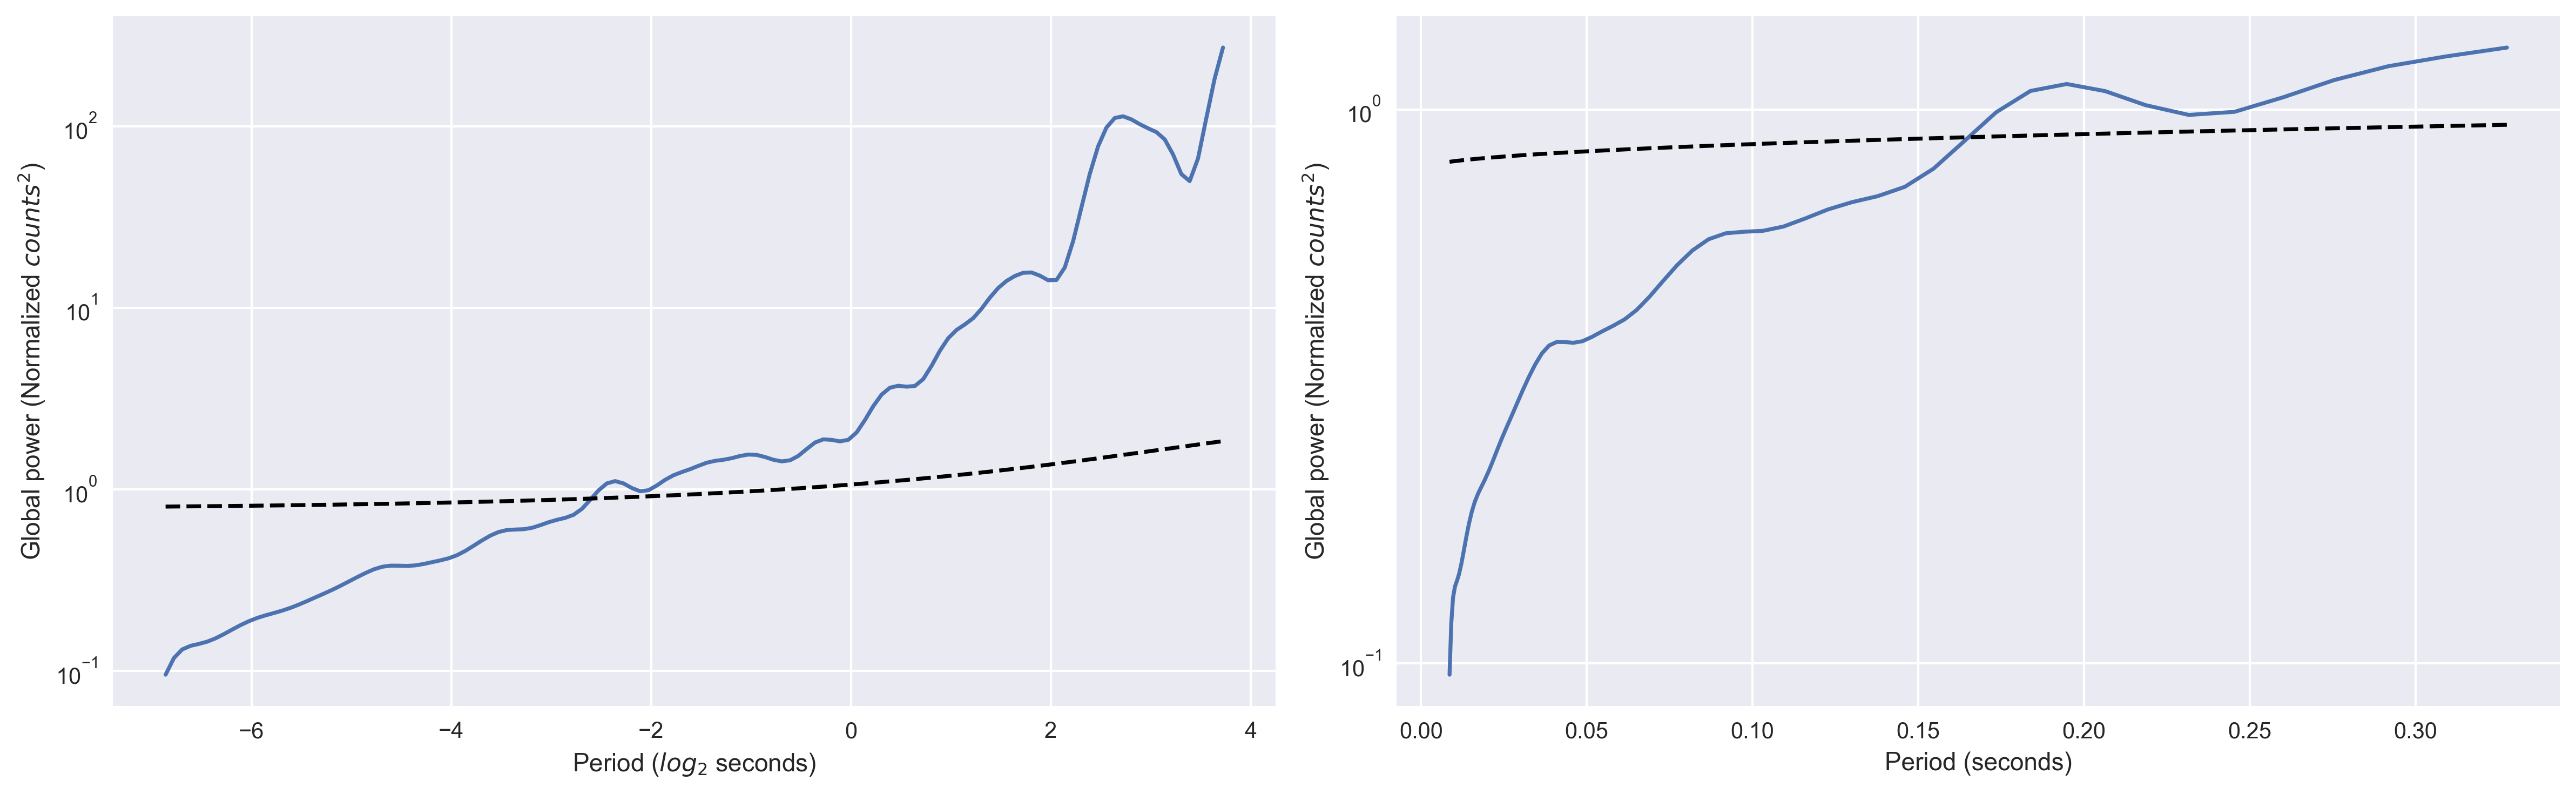

In [20]:
# Ensure the power array is correctly computed
print(f"Power array shape: {power.shape}")

if power.ndim == 1:
    glbl_power = power.mean()  # For 1D array
elif power.ndim == 2:
    glbl_power = power.mean(axis=1)  # For 2D array
else:
    raise ValueError(f"Unexpected power array dimensions: {power.ndim}")

# Continue with the rest of your code


dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# Consider only periods less than 26 seconds
valid_indices = numpy.where(period < 26)[0]
filtered_glbl_power = (var * glbl_power)[valid_indices]
filtered_glbl_signif = glbl_signif[valid_indices]
filtered_periods = period[valid_indices]

# Find the period where var * glbl_power starts consistently exceeding glbl_signif
greater_indices = numpy.where(filtered_glbl_power > filtered_glbl_signif)[0]

if len(greater_indices) > 0:
    start_period = filtered_periods[greater_indices[0]]  # Get the corresponding period value
    print(f"The period where var * glbl_power starts exceeding glbl_signif (period < 26 s): {start_period:.4f} s")
else:
    print("No matching period found (period < 26 s)")

# Save all matching period values
matching_periods = filtered_periods[greater_indices]
numpy.savetxt('./output/' + 'matching_periods' + hnm + '.txt', matching_periods, fmt="%.4f")
print("Matching period values (period < 26 s) have been saved to matching_periods.txt")

plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(np.log2(period[0:128]) ,var * glbl_power[0:128])
plt.plot(np.log2(period[0:128]), glbl_signif[0:128], 'k--')
plt.xlabel('Period ($log_{2}$ seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.yscale('log')
plt.subplot(122)
plt.plot(period[0:64], var * glbl_power[0:64])
plt.plot(period[0:64], glbl_signif[0:64], 'k--')
plt.yscale('log')
plt.xlabel('Period (seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.tight_layout()
plt.show()

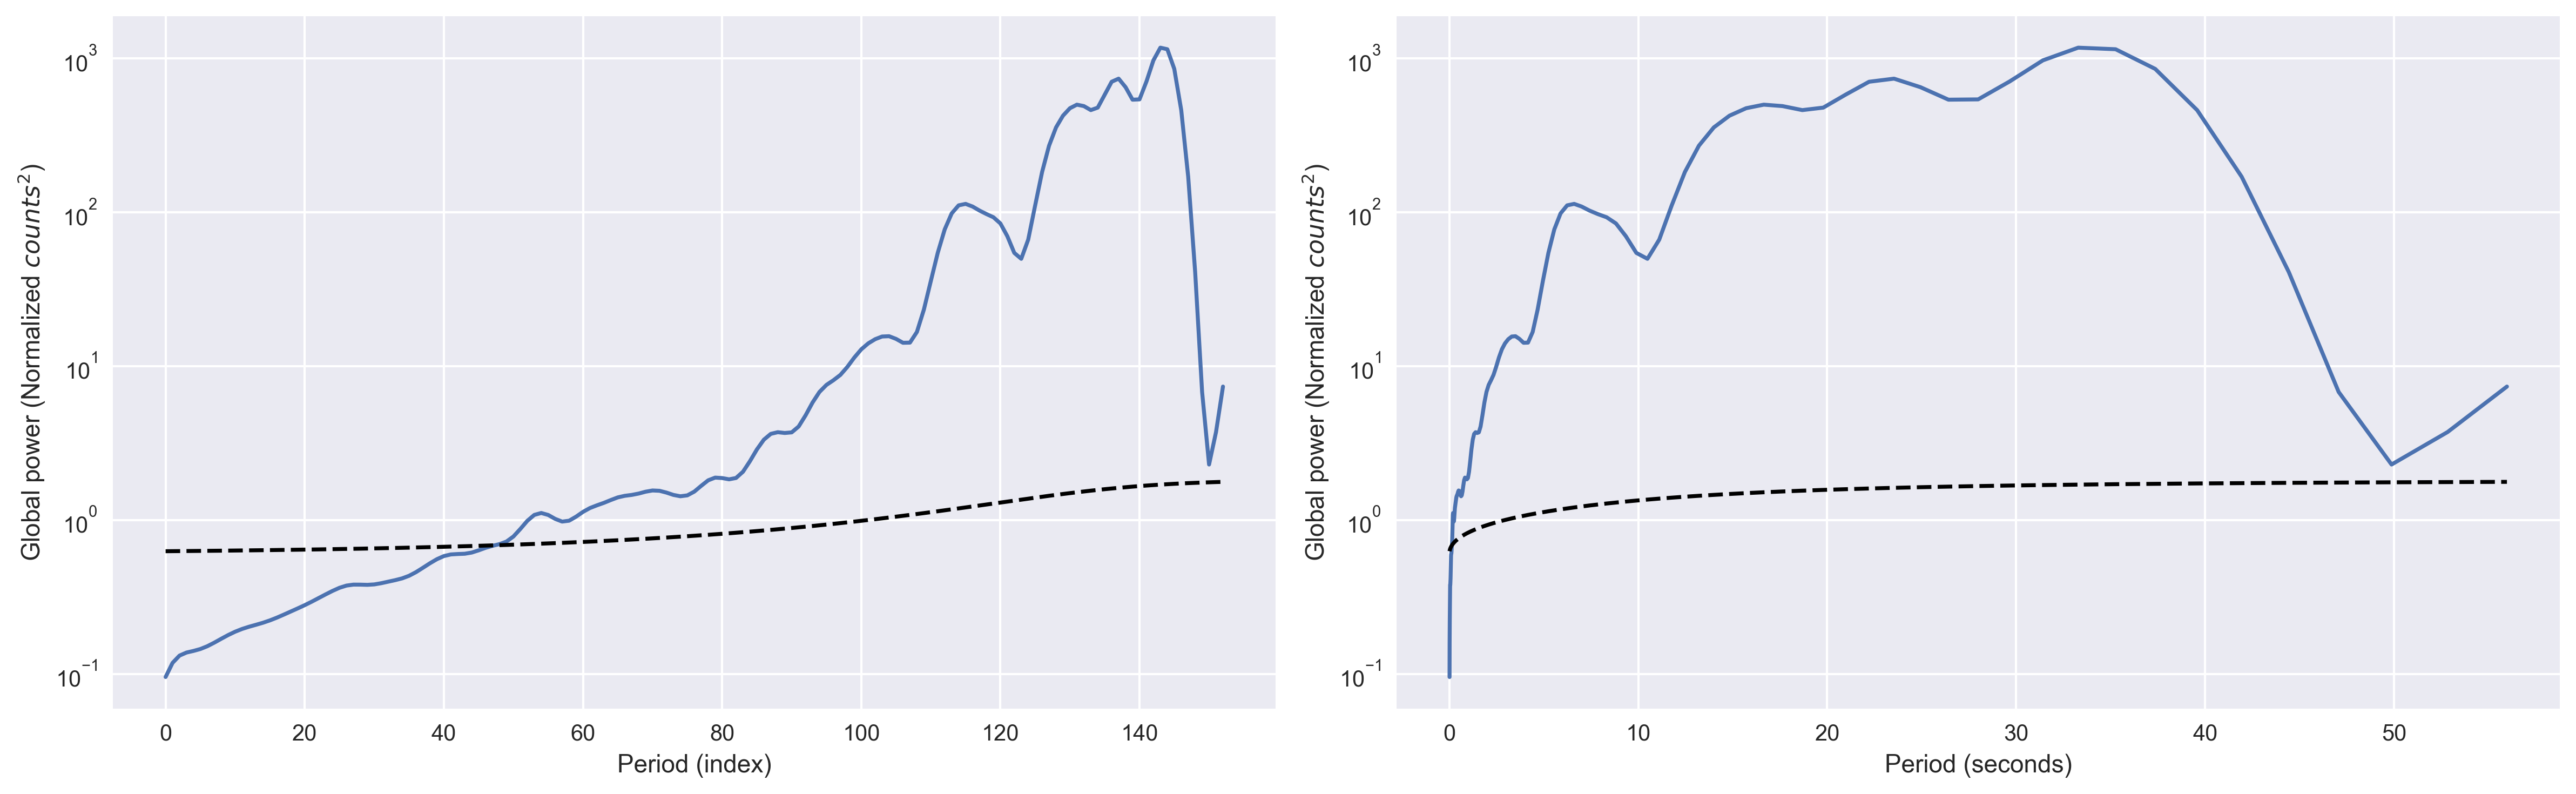

(153,) (153,) (153,)


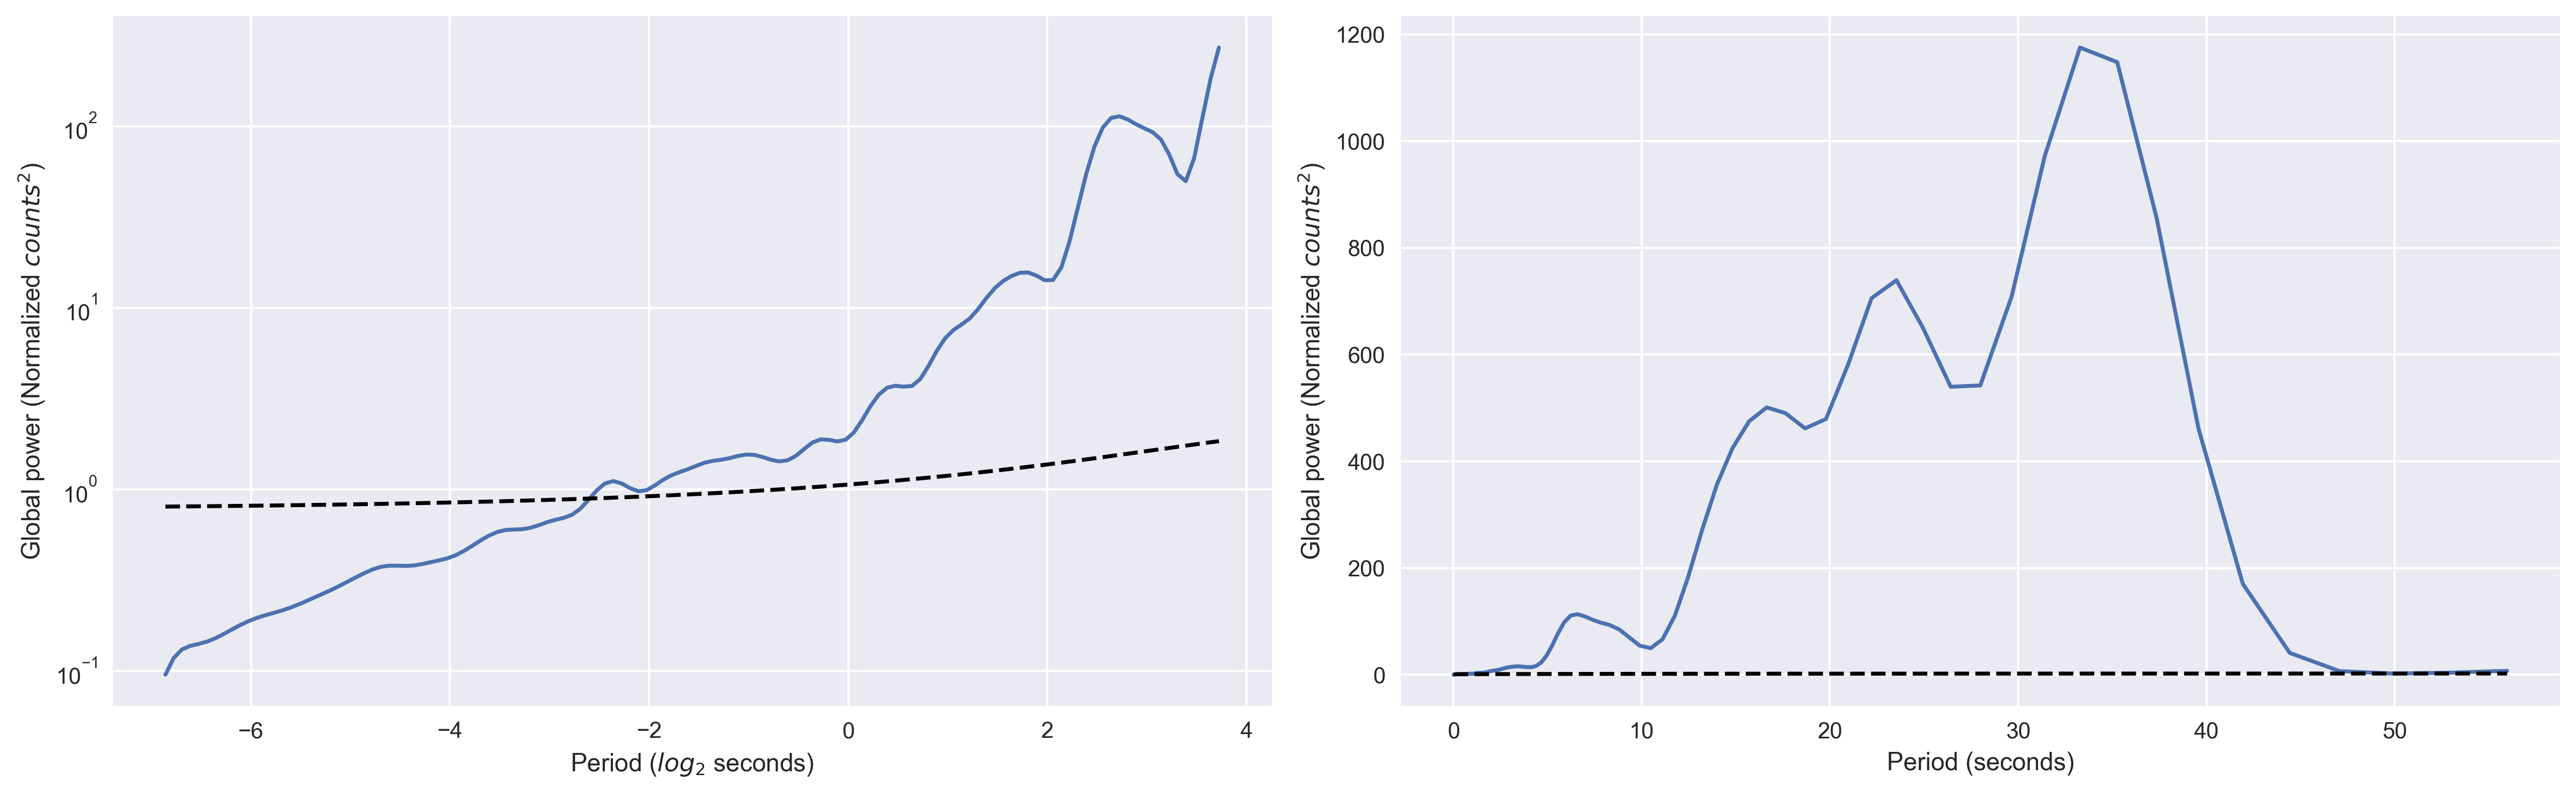

Local peaks (period < 26s, filtered_glbl_power > filtered_glbl_signif):
Period: 0.1948s, Power: 1.1113
Period: 0.4909s, Power: 1.5564
Period: 0.8256s, Power: 1.8869
Period: 1.3884s, Power: 3.7231
Period: 3.4986s, Power: 15.6599
Period: 6.6045s, Power: 113.4632
Local peaks data has been saved to 'local_peaks.txt'


In [21]:
from scipy.signal import find_peaks

plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(var * glbl_power)
plt.plot(var * glbl_signif, 'k--')
plt.xlabel('Period (index)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.yscale('log')
plt.subplot(122)
plt.plot(period, var * glbl_power)
plt.plot(period, var * glbl_signif, 'k--')
plt.yscale('log')
plt.xlabel('Period (seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.tight_layout()
plt.show()

print(glbl_power.shape, glbl_signif.shape, period.shape)

plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(np.log2(period[0:128]) ,var * glbl_power[0:128])
plt.plot(np.log2(period[0:128]), glbl_signif[0:128], 'k--')
plt.xlabel('Period ($log_{2}$ seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.yscale('log')
plt.subplot(122)
plt.plot(period, var * glbl_power)
plt.plot(period, glbl_signif, 'k--')
plt.xlabel('Period (seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.tight_layout()
plt.show()


# Consider only periods less than 26 seconds
valid_indices = numpy.where(period < 13)[0]
filtered_glbl_power = (var * glbl_power)[valid_indices]
filtered_glbl_signif = glbl_signif[valid_indices]
filtered_periods = period[valid_indices]

# Find where filtered_glbl_power > filtered_glbl_signif
greater_indices = numpy.where(filtered_glbl_power > filtered_glbl_signif)[0]

if len(greater_indices) > 0:
    # Extract the corresponding periods and global power values
    matching_periods = filtered_periods[greater_indices]
    matching_power = filtered_glbl_power[greater_indices]

    # Find local peaks in the matching power values
    peaks_indices, _ = find_peaks(matching_power)
    peaks_periods = matching_periods[peaks_indices]
    peaks_power = matching_power[peaks_indices]

    # Combine peaks and power into a single array
    peaks_data = numpy.column_stack((peaks_periods, peaks_power))

    # Print the results
    print("Local peaks (period < 26s, filtered_glbl_power > filtered_glbl_signif):")
    for period, power in peaks_data:
        print(f"Period: {period:.4f}s, Power: {power:.4f}")

    # Save the results to a file
    numpy.savetxt('./output/local_peaks'+ hnm +'.txt', peaks_data, fmt="%.4f", header="Period(s) Power")
    print("Local peaks data has been saved to 'local_peaks.txt'")
else:
    print("No matching periods found (period < 26s)")